In [1]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import pickle
from random import seed
from random import random

# Kolmivuorokohtainen ennuste 22.1.-11.2.2019

In [2]:
start = pd.Timestamp('2018-11-01T00') # Lasten päivystyksen siirtymätodennäköisyyksien laskemisen aloituspäivä
start_L1 = pd.Timestamp('2018-12-01T00') # L1-osaston siirtymätodennäköisyyksien laskemisen aloituspäivä
start_day = pd.Timestamp('2019-01-01T00') # Ennusteajankohta
train_test_day = pd.Timestamp('2019-01-01')
end = pd.Timestamp('2019-05-01T00')

## Lasten päivystys

In [3]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='uranus27_1')
features = ['kaynti_numero', 'potilasnumero', 'henkilotunnus', 'alkuhetki', 'loppuhetki',
       'vo_toimipiste_nimi', 'kayntityyppi_selite', 'varaustyyppi_selite',
       'mista_tuli_selite', 'res_koodi', 'res_selite', 'jh_selite', 
       'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi']
df = dataset.to_pandas_dataframe()[features]
df.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
df.drop_duplicates(subset='kaynti_numero', inplace=True)
df = df[df['varaustyyppi_selite'] != 'PÄIV PKL soitto']
df = df[(df['kayntityyppi_selite'] != 'Hoitokäynti') & (df['kayntityyppi_selite'] != 'Ohjattu muualle') & (df['kayntityyppi_selite'] !='HYKSin Oy:n potilas') & (df['kayntityyppi_selite'] != 'Sarjahoitokäynti') & (df['kayntityyppi_selite'] != 'Ensikäynti')]
df = df[(df.alkuhetki >= start) & (df.alkuhetki < end)]
df_train = df[df.alkuhetki < train_test_day]
df_test = df[df.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
df_train = df_train.sort_values(by='alkuhetki')

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


## L1-osasto

In [4]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset_ward = Dataset.get_by_name(workspace, name='uranus27_2')
features_ward = ['henkilotunnus', 'alkuhetki', 'loppuhetki', 'vo_toimipiste_nimi', 'pot_eala_selite', 'paadg_oire_selite', 'mista_lah_tuli_koodi',
       'mista_lah_tuli_nimi', 'mista_tuli_koodi', 'mista_tuli_selite', 'jatkoh_laitos_nimi',
       'jatkoh_toimipiste_nimi', 'jh_koodi', 'jh_selite', 'osastohoito_numero', 'shjakso_numero']
ward = dataset_ward.to_pandas_dataframe()[features_ward]
ward.replace("", float("NaN"), inplace=True)
ward.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
ward.drop_duplicates(subset='osastohoito_numero', inplace=True)
df = df[(df.alkuhetki >= start_L1) & (df.alkuhetki < end)]
ward_train = ward[ward.alkuhetki < train_test_day]
ward_test = ward[ward.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
ward_train = ward_train.sort_values(by='alkuhetki')

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
/tmp/ipykernel_88875/1379801694.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward.replace("

In [5]:
df_train.kayntityyppi_selite.unique()

array(['Päivystys', 'Uusintakäynti', 'Lisäkäynti', 'Tk-päivystys',
       'Tk-hoitokäynti', 'Poistunut hoidott'], dtype=object)

In [6]:
df_train['alkuhetki'] = pd.to_datetime(df_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train['loppuhetki'] = pd.to_datetime(df_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train = df_train[df_train['alkuhetki'] <= df_train['loppuhetki']]
df_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_train['alkuhetki'], right = df_train['loppuhetki'], closed='neither')
df_train['palveluaika'] = ((df_train['loppuhetki'] - df_train['alkuhetki']).astype('timedelta64[s]') / 3600)
df_train['alku'] = df_train.alkuhetki
df_train['loppu'] = df_train.loppuhetki
df_train.reset_index(drop=True, inplace=True)

In [7]:
df['alkuhetki'] = pd.to_datetime(df['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df['loppuhetki'] = pd.to_datetime(df['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df = df[df['alkuhetki'] <= df['loppuhetki']]
df['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df['alkuhetki'], right = df['loppuhetki'], closed='neither')
df['palveluaika'] = ((df['loppuhetki'] - df['alkuhetki']).astype('timedelta64[s]') / 3600)
df['alku'] = df.alkuhetki
df['loppu'] = df.loppuhetki
df.reset_index(drop=True, inplace=True)

In [8]:
ward_train['alkuhetki'] = pd.to_datetime(ward_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train['loppuhetki'] = pd.to_datetime(ward_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train = ward_train[ward_train['alkuhetki'] <= ward_train['loppuhetki']]
ward_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_train['alkuhetki'], right = ward_train['loppuhetki'], closed='neither')
ward_train['palveluaika'] = np.round(((ward_train['loppuhetki'] - ward_train['alkuhetki']).astype('timedelta64[s]') / 3600 / 24))
ward_train['alku'] = ward_train.alkuhetki
ward_train['loppu'] = ward_train.loppuhetki
ward_train.reset_index(drop=True, inplace=True)

In [9]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600)
ward_test['alku'] = ward_test.alkuhetki
ward_test['loppu'] = ward_test.loppuhetki
ward_test.reset_index(drop=True, inplace=True)

/tmp/ipykernel_88875/929457428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_88875/929457428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")


In [10]:
ward['alkuhetki'] = pd.to_datetime(ward['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward['loppuhetki'] = pd.to_datetime(ward['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward = ward[ward['alkuhetki'] <= ward['loppuhetki']]
ward['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward['alkuhetki'], right = ward['loppuhetki'], closed='neither')
ward['palveluaika'] = ((ward['loppuhetki'] - ward['alkuhetki']).astype('timedelta64[s]') / 3600)
ward['alku'] = ward.alkuhetki
ward['loppu'] = ward.loppuhetki
ward.reset_index(drop=True, inplace=True)

### Siirtymätodennäköisyydet lasten päivystys

In [11]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 1448, 8)]})
timestamp_day = [aika + timedelta(hours=x) for x in range(0, 1440, 8)]
df_train_day = pd.DataFrame(data={'time':timestamp_day})
df_train_day['weekday'] = df_train_day['time'].dt.weekday
df_train_day['month'] = df_train_day['time'].dt.month
df_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_train_day['shift'] = span_day['time'][0:-1].dt.hour
df_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).overlaps(b) for b in df_train['aikaväli']]).sum()

for t in range(len(df_train_day['timespan'])):
    sum = 0
    for a, b in zip(df_train['aikaväli'], df_train['loppuhetki']):
        if ((df_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in df_train_day.loc[t, 'timespan']) == False):
            sum += 1
    df_train_day.loc[t, 'päiv'] = sum
df_train_day['JOL1'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jatkoh_laitos_nimi == 'JOL1'].loppuhetki]).sum()
df_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[df_train.jh_selite == 'Koti'].loppuhetki]).sum()
df_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train[(df_train.jh_selite != 'Koti') & (df_train.jatkoh_laitos_nimi != 'JOL1')].loppuhetki]).sum()
df_train_day.set_index('time', inplace=True)
df_train_day.head()

,weekday,month,timespan,shift,patient_count,päiv,JOL1,koti,muu
time,,,,,,,,,
2018-11-01 00:00:00,3,11,"[2018-11-01, 2018-11-01 08:00:00)",0,0,0.0,0,0,0
2018-11-01 08:00:00,3,11,"[2018-11-01 08:00:00, 2018-11-01 16:00:00)",8,21,4.0,2,15,0
2018-11-01 16:00:00,3,11,"[2018-11-01 16:00:00, 2018-11-02)",16,28,1.0,5,22,0
2018-11-02 00:00:00,4,11,"[2018-11-02, 2018-11-02 08:00:00)",0,6,2.0,0,4,0
2018-11-02 08:00:00,4,11,"[2018-11-02 08:00:00, 2018-11-02 16:00:00)",8,18,6.0,1,10,1


In [12]:
df_train_day['päiv_prob_00'] = df_train_day.iloc[::3, :].päiv / df_train_day.iloc[::3, :].patient_count
df_train_day['päiv_prob_08'] = df_train_day.iloc[1::3, :].päiv / df_train_day.iloc[1::3, :].patient_count
df_train_day['päiv_prob_16'] = df_train_day.iloc[2::3, :].päiv / df_train_day.iloc[2::3, :].patient_count
df_train_day['JOL1_prob_00'] = df_train_day.iloc[::3, :].JOL1 / df_train_day.iloc[::3, :].patient_count
df_train_day['JOL1_prob_08'] = df_train_day.iloc[1::3, :].JOL1 / df_train_day.iloc[1::3, :].patient_count
df_train_day['JOL1_prob_16'] = df_train_day.iloc[2::3, :].JOL1 / df_train_day.iloc[2::3, :].patient_count
df_train_day['koti_prob_00'] = df_train_day.iloc[::3, :].koti / df_train_day.iloc[::3, :].patient_count
df_train_day['koti_prob_08'] = df_train_day.iloc[1::3, :].koti / df_train_day.iloc[1::3, :].patient_count
df_train_day['koti_prob_16'] = df_train_day.iloc[2::3, :].koti / df_train_day.iloc[2::3, :].patient_count
df_train_day['muu_prob_00'] = df_train_day.iloc[::3, :].muu / df_train_day.iloc[::3, :].patient_count
df_train_day['muu_prob_08'] = df_train_day.iloc[1::3, :].muu / df_train_day.iloc[1::3, :].patient_count
df_train_day['muu_prob_16'] = df_train_day.iloc[2::3, :].muu / df_train_day.iloc[2::3, :].patient_count
df_train_day_grouped = df_train_day.groupby(by='weekday')
päiv = df_train_day_grouped.get_group(3)[1:]['päiv_prob_00'].mean()
train_mean = df_train_day_grouped.mean()[['päiv_prob_00', 'JOL1_prob_00', 'muu_prob_00', 'koti_prob_00', 'päiv_prob_08', 'JOL1_prob_08', 'muu_prob_08', 'koti_prob_08', 'päiv_prob_16', 'JOL1_prob_16', 'muu_prob_16', 'koti_prob_16']]
train_mean.loc[3, 'päiv_prob_00'] = päiv
train_mean

/tmp/ipykernel_88875/485355497.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_mean = df_train_day_grouped.mean()[['päiv_prob_00', 'JOL1_prob_00', 'muu_prob_00', 'koti_prob_00', 'päiv_prob_08', 'JOL1_prob_08', 'muu_prob_08', 'koti_prob_08', 'päiv_prob_16', 'JOL1_prob_16', 'muu_prob_16', 'koti_prob_16']]


,päiv_prob_00,JOL1_prob_00,muu_prob_00,koti_prob_00,päiv_prob_08,JOL1_prob_08,muu_prob_08,koti_prob_08,päiv_prob_16,JOL1_prob_16,muu_prob_16,koti_prob_16
weekday,,,,,,,,,,,,
0,0.105335,0.062054,0.000000,0.832612,0.336023,0.028763,0.000000,0.635214,0.071516,0.083565,0.000000,0.847470
1,0.210485,0.083120,0.013889,0.730006,0.328091,0.066003,0.000000,0.611858,0.059353,0.063528,0.005981,0.878817
2,0.072727,0.100406,0.000000,0.826867,0.325207,0.040805,0.009077,0.624910,0.104090,0.071403,0.003788,0.826295
3,0.120800,0.045415,0.008929,0.824857,0.339389,0.062723,0.000000,0.597887,0.127916,0.073157,0.002924,0.796003
4,0.159243,0.113311,0.005848,0.721598,0.360005,0.046048,0.006173,0.612901,0.106156,0.054204,0.000000,0.842109
5,0.172272,0.091531,0.020833,0.715364,0.198763,0.008652,0.002646,0.792585,0.142689,0.050543,0.004444,0.804739
6,0.111499,0.102927,0.027778,0.757796,0.205663,0.011218,0.000000,0.783119,0.130952,0.065949,0.000000,0.812216


In [13]:
df_test['alkuhetki'] = pd.to_datetime(df_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test['loppuhetki'] = pd.to_datetime(df_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test = df_test[df_test['alkuhetki'] <= df_test['loppuhetki']]
df_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_test['alkuhetki'], right = df_test['loppuhetki'], closed='neither')
df_test['palveluaika'] = ((df_test['loppuhetki'] - df_test['alkuhetki']).astype('timedelta64[s]') / 3600)
df_test['alku'] = df_test.alkuhetki
df_test['loppu'] = df_test.loppuhetki
df_test.reset_index(drop=True, inplace=True)

In [14]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 5264, 8)]})
timestamp_day = [aika + timedelta(hours=x) for x in range(0, 5256, 8)]
df_test_day = pd.DataFrame(data={'time':timestamp_day})
df_test_day['weekday'] = df_test_day['time'].dt.weekday
df_test_day['month'] = df_test_day['time'].dt.month
df_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()
df_test_day.set_index('time', inplace=True)

In [15]:
print(df_train.jatkoh_laitos_nimi.unique())
print('JOL1 osastolle siirtyneet:', len(df_train[df_train.jatkoh_laitos_nimi == 'JOL1']) / len(df_train) * 100)
print('Ylipäätään jollekin osastolle siirtyneet:', len(df_train[df_train.jatkoh_laitos_nimi != '']) / len(df_train) * 100)
print('Sairaalaan jääneet:', len(df_train[df_train.jh_selite == 'Sairaala']) / len(df_train) * 100)

['' 'JOL1' 'LAVARUUS' 'HYKS-SHA' 'NPSN1' 'LVUORI' 'JON6C' 'JOL2' 'LTEHO'
 'NPSN2' 'LTÄHTI']
JOL1 osastolle siirtyneet: 6.744457409568261
Ylipäätään jollekin osastolle siirtyneet: 7.141190198366394
Sairaalaan jääneet: 7.024504084014002


### Siirtymätodennäköisyydet JOL1

In [16]:
aika = start_L1
span_day = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 752, 8)]}) # 1448 752
timestamp_day = [aika + timedelta(hours=x) for x in range(0, 744, 8)] # 1440 744
ward_train_day = pd.DataFrame(data={'time':timestamp_day})
ward_train_day['weekday'] = ward_train_day['time'].dt.weekday
ward_train_day['month'] = ward_train_day['time'].dt.month
ward_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_train_day['shift'] = span_day['time'][0:-1].dt.hour
ward_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).overlaps(b) for b in ward_train['aikaväli']]).sum()

for t in range(len(ward_train_day['timespan'])):
    sum = 0
    for a, b in zip(ward_train['aikaväli'], ward_train['loppuhetki']):
        if ((ward_train_day.loc[t, 'timespan'].overlaps(a)) == True) & ((b in ward_train_day.loc[t, 'timespan']) == False):
            sum += 1
    ward_train_day.loc[t, 'JOL1'] = sum
ward_train_day['koti'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[ward_train.jh_selite == 'Koti'].loppuhetki]).sum()
ward_train_day['muu'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train[ward_train.jh_selite == 'Sairaala'].loppuhetki]).sum()
ward_train_day.set_index('time', inplace=True)
ward_train_var = ward_train_day
ward_train_day = ward_train_day[ward_train_day.index >= start_L1]
ward_train_day.head()

,weekday,month,timespan,shift,patient_count,JOL1,koti,muu
time,,,,,,,,
2018-12-01 00:00:00,5,12,"[2018-12-01, 2018-12-01 08:00:00)",0,13,13.0,0,0
2018-12-01 08:00:00,5,12,"[2018-12-01 08:00:00, 2018-12-01 16:00:00)",8,14,12.0,1,1
2018-12-01 16:00:00,5,12,"[2018-12-01 16:00:00, 2018-12-02)",16,15,14.0,1,0
2018-12-02 00:00:00,6,12,"[2018-12-02, 2018-12-02 08:00:00)",0,15,15.0,0,0
2018-12-02 08:00:00,6,12,"[2018-12-02 08:00:00, 2018-12-02 16:00:00)",8,16,9.0,7,0


In [17]:
ward_train_day['JOL1_prob_00'] = ward_train_day.iloc[::3, :].JOL1 / ward_train_day.iloc[::3, :].patient_count
ward_train_day['JOL1_prob_08'] = ward_train_day.iloc[1::3, :].JOL1 / ward_train_day.iloc[1::3, :].patient_count
ward_train_day['JOL1_prob_16'] = ward_train_day.iloc[2::3, :].JOL1 / ward_train_day.iloc[2::3, :].patient_count
ward_train_day['koti_prob_00'] = ward_train_day.iloc[::3, :].koti / ward_train_day.iloc[::3, :].patient_count
ward_train_day['koti_prob_08'] = ward_train_day.iloc[1::3, :].koti / ward_train_day.iloc[1::3, :].patient_count
ward_train_day['koti_prob_16'] = ward_train_day.iloc[2::3, :].koti / ward_train_day.iloc[2::3, :].patient_count
ward_train_day['muu_prob_00'] = ward_train_day.iloc[::3, :].muu / ward_train_day.iloc[::3, :].patient_count
ward_train_day['muu_prob_08'] = ward_train_day.iloc[1::3, :].muu / ward_train_day.iloc[1::3, :].patient_count
ward_train_day['muu_prob_16'] = ward_train_day.iloc[2::3, :].muu / ward_train_day.iloc[2::3, :].patient_count
ward_train_day_grouped = ward_train_day.groupby(by='weekday')
ward_mean = ward_train_day_grouped.mean()
ward_mean

/tmp/ipykernel_88875/1570025885.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_mean = ward_train_day_grouped.mean()


,month,shift,patient_count,JOL1,koti,muu,JOL1_prob_00,JOL1_prob_08,JOL1_prob_16,koti_prob_00,koti_prob_08,koti_prob_16,muu_prob_00,muu_prob_08,muu_prob_16
weekday,,,,,,,,,,,,,,,
0,12.0,8.0,14.066667,12.000000,1.933333,0.066667,1.000000,0.618281,0.967949,0.0,0.354570,0.032051,0.000000,0.015385,0.000000
1,12.0,8.0,12.416667,10.666667,1.750000,0.000000,1.000000,0.648611,0.982143,0.0,0.351389,0.017857,0.000000,0.000000,0.000000
2,12.0,8.0,14.416667,13.083333,1.333333,0.000000,1.000000,0.773866,0.959030,0.0,0.226134,0.040970,0.000000,0.000000,0.000000
3,12.0,8.0,15.416667,13.666667,1.750000,0.000000,1.000000,0.712662,0.972470,0.0,0.287338,0.027530,0.000000,0.000000,0.000000
4,12.0,8.0,16.666667,14.833333,1.833333,0.000000,1.000000,0.732871,0.977273,0.0,0.267129,0.022727,0.000000,0.000000,0.000000
5,12.0,8.0,15.400000,13.600000,1.666667,0.200000,1.000000,0.763741,0.887270,0.0,0.212882,0.109110,0.000000,0.023377,0.015385
6,12.0,8.0,14.266667,12.466667,1.733333,0.066667,0.977778,0.673736,0.988235,0.0,0.326264,0.011765,0.022222,0.000000,0.000000


In [18]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600)

In [19]:
aika = train_test_day
span_day_test = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 5264, 8)]})
timestamp_day_test = [aika + timedelta(hours=x) for x in range(0, 5256, 8)]
ward_test_day = pd.DataFrame(data={'time':timestamp_day_test})
ward_test_day['weekday'] = ward_test_day['time'].dt.weekday
ward_test_day['month'] = ward_test_day['time'].dt.month
ward_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day_test['time'][0:-1], right = span_day_test['time'][1:], closed='left')
ward_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()
ward_test_day.set_index('time', inplace=True)

In [20]:
# Siirtymätodennäköisyyksien normalisointi 1
def smoothen_transition_probs(df_mean, columns):
    '''
    Input parameters:
        df_mean (DataFrame): mean transition probabilities
        columns (list): columns considered in normalization, 
        one inner list corresponds the probabilities for one row
    Output parameters:
        df_mean (DataFrame): normalized mean transition probabilities
    '''
    for names in columns:
        for row in range(len(df_mean)):
            probs_sum = np.sum([df_mean.at[row, n] for n in names])
            for n in names:
                df_mean.loc[df_mean.index == row, n] = df_mean.loc[df_mean.index == row, n] / probs_sum + 0.000000001
    return df_mean
    
train_mean = train_mean.reset_index()
columns = [['päiv_prob_00', 'JOL1_prob_00', 'muu_prob_00', 'koti_prob_00'],
           ['päiv_prob_08', 'JOL1_prob_08', 'muu_prob_08', 'koti_prob_08'],
           ['päiv_prob_16', 'JOL1_prob_16', 'muu_prob_16', 'koti_prob_16']]
train_mean = smoothen_transition_probs(train_mean, columns)

ward_mean = ward_mean.reset_index()
columns_ward = [['JOL1_prob_00', 'muu_prob_00', 'koti_prob_00'],
                ['JOL1_prob_08', 'muu_prob_08', 'koti_prob_08'],
                ['JOL1_prob_16', 'muu_prob_16', 'koti_prob_16']]
ward_mean = smoothen_transition_probs(ward_mean, columns_ward)

## Siirtymämatriisit

In [21]:
#           päivystys  JOL1  muu  koti
# päivystys
# JOL1
# muu
# koti


# 00-08
T_mon_midnight = [[train_mean.at[0, 'päiv_prob_00'], train_mean.at[0, 'JOL1_prob_00'], train_mean.at[0, 'muu_prob_00'], train_mean.at[0, 'koti_prob_00']],
         [0, ward_mean.at[0, 'JOL1_prob_00'], ward_mean.at[0, 'muu_prob_00'], ward_mean.at[0, 'koti_prob_00']],       
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_tue_midnight = [[train_mean.at[1, 'päiv_prob_00'], train_mean.at[1, 'JOL1_prob_00'], train_mean.at[1, 'muu_prob_00'], train_mean.at[1, 'koti_prob_00']],
         [0, ward_mean.at[1, 'JOL1_prob_00'], ward_mean.at[1, 'muu_prob_00'], ward_mean.at[1, 'koti_prob_00']],
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_wed_midnight = [[train_mean.at[2, 'päiv_prob_00'], train_mean.at[2, 'JOL1_prob_00'], train_mean.at[2, 'muu_prob_00'], train_mean.at[2, 'koti_prob_00']],
         [0, ward_mean.at[2, 'JOL1_prob_00'], ward_mean.at[2, 'muu_prob_00'], ward_mean.at[2, 'koti_prob_00']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_thu_midnight = [[train_mean.at[3, 'päiv_prob_00'], train_mean.at[3, 'JOL1_prob_00'], train_mean.at[3, 'muu_prob_00'], train_mean.at[3, 'koti_prob_00']],
         [0, ward_mean.at[3, 'JOL1_prob_00'], ward_mean.at[3, 'muu_prob_00'], ward_mean.at[3, 'koti_prob_00']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_fri_midnight = [[train_mean.at[4, 'päiv_prob_00'], train_mean.at[4, 'JOL1_prob_00'], train_mean.at[4, 'muu_prob_00'], train_mean.at[4, 'koti_prob_00']],
         [0, ward_mean.at[4, 'JOL1_prob_00'], ward_mean.at[4, 'muu_prob_00'], ward_mean.at[4, 'koti_prob_00']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]
         
T_sat_midnight = [[train_mean.at[5, 'päiv_prob_00'], train_mean.at[5, 'JOL1_prob_00'], train_mean.at[5, 'muu_prob_00'], train_mean.at[5, 'koti_prob_00']],
         [0, ward_mean.at[5, 'JOL1_prob_00'], ward_mean.at[5, 'muu_prob_00'], ward_mean.at[5, 'koti_prob_00']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_sun_midnight = [[train_mean.at[6, 'päiv_prob_00'], train_mean.at[6, 'JOL1_prob_00'], train_mean.at[6, 'muu_prob_00'], train_mean.at[6, 'koti_prob_00']],
         [0, ward_mean.at[6, 'JOL1_prob_00'], ward_mean.at[6, 'muu_prob_00'], ward_mean.at[6, 'koti_prob_00']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]


# 08-16
T_mon_day = [[train_mean.at[0, 'päiv_prob_08'], train_mean.at[0, 'JOL1_prob_08'], train_mean.at[0, 'muu_prob_08'], train_mean.at[0, 'koti_prob_08']],
         [0, ward_mean.at[0, 'JOL1_prob_08'], ward_mean.at[0, 'muu_prob_08'], ward_mean.at[0, 'koti_prob_08']],       
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_tue_day = [[train_mean.at[1, 'päiv_prob_08'], train_mean.at[1, 'JOL1_prob_08'], train_mean.at[1, 'muu_prob_08'], train_mean.at[1, 'koti_prob_08']],
         [0, ward_mean.at[1, 'JOL1_prob_08'], ward_mean.at[1, 'muu_prob_08'], ward_mean.at[1, 'koti_prob_08']],
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_wed_day = [[train_mean.at[2, 'päiv_prob_08'], train_mean.at[2, 'JOL1_prob_08'], train_mean.at[2, 'muu_prob_08'], train_mean.at[2, 'koti_prob_08']],
         [0, ward_mean.at[2, 'JOL1_prob_08'], ward_mean.at[2, 'muu_prob_08'], ward_mean.at[2, 'koti_prob_08']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_thu_day = [[train_mean.at[3, 'päiv_prob_08'], train_mean.at[3, 'JOL1_prob_08'], train_mean.at[3, 'muu_prob_08'], train_mean.at[3, 'koti_prob_08']],
         [0, ward_mean.at[3, 'JOL1_prob_08'], ward_mean.at[3, 'muu_prob_08'], ward_mean.at[3, 'koti_prob_08']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_fri_day = [[train_mean.at[4, 'päiv_prob_08'], train_mean.at[4, 'JOL1_prob_08'], train_mean.at[4, 'muu_prob_08'], train_mean.at[4, 'koti_prob_08']],
         [0, ward_mean.at[4, 'JOL1_prob_08'], ward_mean.at[4, 'muu_prob_08'], ward_mean.at[4, 'koti_prob_08']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]
         
T_sat_day = [[train_mean.at[5, 'päiv_prob_08'], train_mean.at[5, 'JOL1_prob_08'], train_mean.at[5, 'muu_prob_08'], train_mean.at[5, 'koti_prob_08']],
         [0, ward_mean.at[5, 'JOL1_prob_08'], ward_mean.at[5, 'muu_prob_08'], ward_mean.at[5, 'koti_prob_08']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_sun_day = [[train_mean.at[6, 'päiv_prob_08'], train_mean.at[6, 'JOL1_prob_08'], train_mean.at[6, 'muu_prob_08'], train_mean.at[6, 'koti_prob_08']],
         [0, ward_mean.at[6, 'JOL1_prob_08'], ward_mean.at[6, 'muu_prob_08'], ward_mean.at[6, 'koti_prob_08']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]


# 16-24
T_mon_night = [[train_mean.at[0, 'päiv_prob_16'], train_mean.at[0, 'JOL1_prob_16'], train_mean.at[0, 'muu_prob_16'], train_mean.at[0, 'koti_prob_16']],
         [0, ward_mean.at[0, 'JOL1_prob_16'], ward_mean.at[0, 'muu_prob_16'], ward_mean.at[0, 'koti_prob_16']],       
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_tue_night = [[train_mean.at[1, 'päiv_prob_16'], train_mean.at[1, 'JOL1_prob_16'], train_mean.at[1, 'muu_prob_16'], train_mean.at[1, 'koti_prob_16']],
         [0, ward_mean.at[1, 'JOL1_prob_16'], ward_mean.at[1, 'muu_prob_16'], ward_mean.at[1, 'koti_prob_16']],
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_wed_night = [[train_mean.at[2, 'päiv_prob_16'], train_mean.at[2, 'JOL1_prob_16'], train_mean.at[2, 'muu_prob_16'], train_mean.at[2, 'koti_prob_16']],
         [0, ward_mean.at[2, 'JOL1_prob_16'], ward_mean.at[2, 'muu_prob_16'], ward_mean.at[2, 'koti_prob_16']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_thu_night = [[train_mean.at[3, 'päiv_prob_16'], train_mean.at[3, 'JOL1_prob_16'], train_mean.at[3, 'muu_prob_16'], train_mean.at[3, 'koti_prob_16']],
         [0, ward_mean.at[3, 'JOL1_prob_16'], ward_mean.at[3, 'muu_prob_16'], ward_mean.at[3, 'koti_prob_16']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_fri_night = [[train_mean.at[4, 'päiv_prob_16'], train_mean.at[4, 'JOL1_prob_16'], train_mean.at[4, 'muu_prob_16'], train_mean.at[4, 'koti_prob_16']],
         [0, ward_mean.at[4, 'JOL1_prob_16'], ward_mean.at[4, 'muu_prob_16'], ward_mean.at[4, 'koti_prob_16']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]
         
T_sat_night = [[train_mean.at[5, 'päiv_prob_16'], train_mean.at[5, 'JOL1_prob_16'], train_mean.at[5, 'muu_prob_16'], train_mean.at[5, 'koti_prob_16']],
         [0, ward_mean.at[5, 'JOL1_prob_16'], ward_mean.at[5, 'muu_prob_16'], ward_mean.at[5, 'koti_prob_16']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]

T_sun_night = [[train_mean.at[6, 'päiv_prob_16'], train_mean.at[6, 'JOL1_prob_16'], train_mean.at[6, 'muu_prob_16'], train_mean.at[6, 'koti_prob_16']],
         [0, ward_mean.at[6, 'JOL1_prob_16'], ward_mean.at[6, 'muu_prob_16'], ward_mean.at[6, 'koti_prob_16']], 
         [0,        0,        1,        0],
         [0,        0,        1,        0]]


## Hybridimalli

In [22]:
def sampleMultiDist(row_probs, state):
    '''
    Input parameters:
        row_probs (list): unit's transition propability row
        state (int): initial state
    Output parameters:
        next (int): next state
    '''
    sample = np.random.uniform(0.0, 1.0)
    cum_probs = np.cumsum(row_probs)
    cum_probs = np.insert(cum_probs, state, 0, 0)
    i = (np.where(cum_probs < sample))[0]
    next = i[len(i) - 1]
    return next

def Markov(initial_state, day):
    '''
    Input parameters:
        initial_state (int): 
        day (int): datapoint from the prediction start day 1-126
    Output parameters:
        current_states (array): array of patient's states
    '''
    state = np.array([[0.0, 0.0, 0.0, 0.0]])
    state[0, initial_state] = 1.0
    current_state = initial_state
    current_states = np.array([current_state])
    state_hist = state
    seed(4)
    
    d = 0
    while ((d < 125 - day) & (current_state != 2) & (current_state != 3)):

        if (d + 19) % 21 == 0:
            current_row = np.ma.masked_values((T_mon_midnight[current_state]), 0.0)
        elif (d + 20) % 21 == 0:
            current_row = np.ma.masked_values((T_mon_day[current_state]), 0.0)
        elif (d + 21) % 21 == 0:
            current_row = np.ma.masked_values((T_mon_night[current_state]), 0.0)
        elif (d + 16) % 21 == 0:
            current_row = np.ma.masked_values((T_tue_midnight[current_state]), 0.0)
        elif (d + 17) % 21 == 0:
            current_row = np.ma.masked_values((T_tue_day[current_state]), 0.0)
        elif (d + 18) % 21 == 0:
            current_row = np.ma.masked_values((T_tue_night[current_state]), 0.0)
        elif (d + 13) % 21 == 0:
            current_row = np.ma.masked_values((T_wed_midnight[current_state]), 0.0)
        elif (d + 14) % 21 == 0:
            current_row = np.ma.masked_values((T_wed_day[current_state]), 0.0)
        elif (d + 15) % 21 == 0:
            current_row = np.ma.masked_values((T_wed_night[current_state]), 0.0)
        elif (d + 10) % 21 == 0:
            current_row = np.ma.masked_values((T_thu_midnight[current_state]), 0.0)
        elif (d + 11) % 21 == 0:
            current_row = np.ma.masked_values((T_thu_day[current_state]), 0.0)
        elif (d + 12) % 21 == 0:
            current_row = np.ma.masked_values((T_thu_night[current_state]), 0.0)
        elif (d + 7) % 21 == 0:
            current_row = np.ma.masked_values((T_fri_midnight[current_state]), 0.0)
        elif (d + 8) % 21 == 0:
            current_row = np.ma.masked_values((T_fri_day[current_state]), 0.0)
        elif (d + 9) % 21 == 0:
            current_row = np.ma.masked_values((T_fri_night[current_state]), 0.0)
        elif (d + 4) % 21 == 0:
            current_row = np.ma.masked_values((T_sat_midnight[current_state]), 0.0)
        elif (d + 5) % 21 == 0:
            current_row = np.ma.masked_values((T_sat_day[current_state]), 0.0)
        elif (d + 6) % 21 == 0:
            current_row = np.ma.masked_values((T_sat_night[current_state]), 0.0)
        elif (d + 2) % 21 == 0:
            current_row = np.ma.masked_values((T_sun_day[current_state]), 0.0)
        elif (d + 3) % 21 == 0:
            current_row = np.ma.masked_values((T_sun_night[current_state]), 0.0)
        else:
            current_row = np.ma.masked_values((T_sun_midnight[current_state]), 0.0)

        next = sampleMultiDist(current_row, initial_state)
        state = np.array([[0, 0, 0, 0]])
        state[0, next] = 1.0
        state_hist = np.append(state_hist, state, axis=0)
        current_state = next
        d += 1
        current_states = np.append(current_states, [current_state], axis=0)

    return current_states


In [23]:
def staying_in_care(unit_df, start_day):
    '''
    Input parameters:
        unit_df (DataFrame): unit data
        start_day (Timestamp): the prediction day
    Output parameters:
        current_pc['patient_count'][0] (int): number of patients in care in the unit during the start time of the prediction 
    '''
    current_pc = pd.DataFrame(data={'time':[start_day]})
    current_pc['timespan'] = pd.Interval(left=start_day - timedelta(minutes=1), right=start_day + timedelta(minutes=1), closed='neither')
    current_pc['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(current_pc['timespan']).overlaps(b) for b in unit_df['aikaväli']]).sum()
    return current_pc['patient_count'][0]

ER_care = staying_in_care(df, start_day)
ward_care = staying_in_care(ward, start_day)
print('Päivystyksessä hoidossa:', ER_care)
print('Osastolla hoidossa:', ward_care)

Päivystyksessä hoidossa: 9
Osastolla hoidossa: 18


In [24]:
def network(state, prediction): 
    '''
    Input parameters:
        state (int): state number of the unit, the column of the transition matrix
        prediction (list): arriving patient predictions 
    Output parameters:
        simulations (array): array of patients simulations
        prediction (list): arriving patient predictions 
    '''
    simulations = np.zeros((42*3, 1))
    # Simulaatio jokaiselle uudelle potilaalle jokaista ennustettavaa aikaväliä kohden
    for j in range(len(prediction)):
        for k in range(prediction[j]):
            result = Markov(state, j)
            result = result.reshape((len(result), 1))
            sim = np.zeros((42*3, 1))
            sim[:] = np.nan
            sim[j:len(result) + j] = result
            simulations = np.append(simulations, sim, axis=1) 

    simulations = simulations[:, 1:]
    return simulations, prediction

In [25]:
def transferred_to(results, state):
    '''
    Input parameters:
        results (DataFrame): results of one unit
        state (int): unit's state
    Output parameters:
        transferred (array): array of number of patients transferred to the considered unit (state)
    '''
    transferred = np.array([0])
    for i in range(1, 42*3):
        rows = results[(results[i-1] != state) & (results[i] == state)]
        transferred = np.append(transferred, len(rows))
    return transferred
        
def remove_transferred(results, transferred, prediction):
    '''
    Input parameters:
        results (DataFrame): results of one unit 
        transferred (array): array of number of patients transferred to the considered unit (state)
        prediction (list): arriving patient predictions
    Output parameters:
        results (array): array of patients simulations after removal of patients transferred inside the network
    '''
    added = 0
    for i in range(42*3):
        removed = transferred[i]
        if removed <= prediction[i]:
            added += prediction[i]
            results = np.delete(results, np.arange(added-removed, added), axis=1)
            added -= removed
        else:
            added += prediction[i]
    return results


In [26]:
def network_combination(unit_results):
    '''
    Input parameters:
        unit_results (DataFrame): results of one unit
    Output parameters:
        state_counts (DataFrame): patient counts of the considered states every 8 hours
    '''
    state_counts = pd.DataFrame(columns=['0', '1', '2', '3'])
    states = pd.RangeIndex(start=0, stop=4)
    states_per_day = pd.DataFrame(unit_results)
    for day in range(len(states_per_day)):
        count = states_per_day.loc[day].value_counts()
        for i in states:
            if i not in count:
                count.loc[i] = 0
        count = count.sort_index()
        state_counts.loc[day] = count.values
    return state_counts


In [27]:
def full_simulation(in_care, prediction_day):
    '''
    Input parameters:
        in_care (list): list of integers describing the number of patients in care in the start of prediction
        prediction_day (int): the day number of year 
    Output parameters:
        final_results (DataFrame): one full simulation predicting patient counts for all considered units
    '''
    final_results = np.zeros([42*3, 4], dtype=int)
    unit_amount = 2
    prediction_model_names = ['tbats_ER_2017-2019-triple_final.pkl', 'tbats_L1_2017-2019-triple_final.pkl']
    for i in range(unit_amount):
        ts_model = pickle.load(open(prediction_model_names[i], 'rb'))

        prediction_year = np.ceil(ts_model.forecast(steps=365*3) * 1.0).astype(int) # TBATS
        prediction = prediction_year[prediction_day:(prediction_day + 42*3)]
        # Hoidossa olevien potilaiden lisäys
        prediction[0] += in_care[i]
        results, prediction = network(i, prediction)
        # Verkossa siirtyvien potilaiden poisto
        if i > 0:
            transferred = transferred_to(pd.DataFrame(results.transpose()), i)
            results = remove_transferred(results, transferred, prediction)
        counts = network_combination(results)
        final_results += counts
    return final_results

ER_care = staying_in_care(df, start_day)
ward_care = staying_in_care(ward, start_day)
in_care = np.array([ER_care, ward_care])
prediction_day = (start_day.dayofyear - 1) * 3
simulations = 50
final_results = np.zeros([42*3, 4], dtype=int)
all_results = pd.DataFrame()
for s in range(simulations):
    sim_results = full_simulation(in_care, prediction_day)
    final_results += sim_results
    all_results = pd.concat([all_results, sim_results], axis=0)
final_results = np.round(final_results.div(simulations))
print(final_results)

        0     1    2     3
0    13.0  20.0  0.0   0.0
1    21.0  20.0  0.0  12.0
2    38.0  14.0  0.0  25.0
3     6.0  17.0  0.0  32.0
4    20.0  16.0  0.0   6.0
..    ...   ...  ...   ...
121  41.0  14.0  0.0  12.0
122  49.0  16.0  0.0  35.0
123   5.0  17.0  0.0  44.0
124  24.0  14.0  0.0   7.0
125  44.0  16.0  0.0  21.0

[126 rows x 4 columns]


### Historiadatan varianssi ja 95 % luottamusväli

In [28]:
def pc_mean(df_pc):
    '''
    Input parameters:
        df_pc (DataFrame): patient counts of triple shifts
    Output parameters:
        means (DataFrame): patient count means of triple shifts
    '''
    means = np.zeros([7, 3], dtype=float)
    for i in range(7):
        group = df_pc[df_pc.weekday == i]
        ind_midnight = group.iloc[::3, :].patient_count.mean()
        ind_day = group.iloc[1::3, :].patient_count.mean()
        ind_night = group.iloc[2::3, :].patient_count.mean()
        means[i, :] = [ind_midnight, ind_day, ind_night]
    return means

def pc_variance(df, mean):
    '''
    Input parameters:
        df (DataFrame): patient counts of triple shifts
        mean (group DataFrame): patient count means of triple shifts
    Output parameters:
        variances (DataFrame): patient count variances of triple shifts
    '''
    variances = np.zeros([7, 3], dtype=float)
    for i in range(7):
        var_midnight = 0
        var_day = 0
        var_night = 0
        group = df[df.weekday == i]
        for p in range(0, len(group), 3):
            ind_midnight = group.iloc[p][2]
            ind_day = group.iloc[p + 1][2]
            ind_night = group.iloc[p + 2][2]
            var_midnight += np.power((ind_midnight - mean[i, 0]), 2)
            var_day += np.power((ind_day - mean[i, 1]), 2)
            var_night += np.power((ind_night - mean[i, 2]), 2)

        variances[i, 0] = var_midnight / (len(group) / 3)
        variances[i, 1] = var_day / (len(group) / 3)
        variances[i, 2] = var_night / (len(group) / 3)

    variances = pd.DataFrame(variances, columns=['00', '08', '16'])
    return variances

In [29]:
train_pc = df_train_day[['weekday', 'shift', 'patient_count']]
train_pc_mean = pc_mean(train_pc)
#print(train_pc_mean)

train_pc_var = pc_variance(train_pc, train_pc_mean)
train_ninety_five_est = np.sqrt(train_pc_var) * 2
train_ninety_five = pd.DataFrame(train_ninety_five_est).rolling(3, min_periods=1, center=True).mean()
train_ninety_five.iloc[0, :] = np.mean([train_ninety_five_est.iloc[0, :], train_ninety_five_est.iloc[1, :], train_ninety_five_est.iloc[6, :]], axis=0)
train_ninety_five.iloc[6, :] = np.mean([train_ninety_five_est.iloc[0, :], train_ninety_five_est.iloc[5, :], train_ninety_five_est.iloc[6, :]], axis=0)
#print(train_ninety_five)

ward_pc = ward_train_var[['weekday', 'shift', 'patient_count']]
ward_pc_mean = pc_mean(ward_pc)
#print(train_pc_mean)

ward_pc_var = pc_variance(ward_pc, ward_pc_mean)
ward_ninety_five_est = np.sqrt(ward_pc_var) * 2
ward_ninety_five = pd.DataFrame(ward_ninety_five_est).rolling(3, min_periods=1, center=True).mean()
ward_ninety_five.iloc[0, :] = np.mean([ward_ninety_five_est.iloc[0, :], ward_ninety_five_est.iloc[1, :], ward_ninety_five_est.iloc[6, :]], axis=0)
ward_ninety_five.iloc[6, :] = np.mean([ward_ninety_five_est.iloc[0, :], ward_ninety_five_est.iloc[5, :], ward_ninety_five_est.iloc[6, :]], axis=0)
#print(ward_ninety_five)

### Simulaatioiden varianssi ja 95 % luottamusväli

In [30]:
def dispersion(results_ind, mean, simulations):
    var = np.zeros([42*3, 4], dtype=int)
    results = results_ind.reset_index(drop=True)
    for i in range(simulations):
        var += (results.loc[i*42*3:(i+1)*41*3 + i*3 + 2].reset_index(drop=True) - mean).pow(2)      
    variance = var / simulations
    std = np.sqrt(variance)
    return variance, std

#print(final_results)
variance_results, std_results = dispersion(all_results, final_results, simulations)
#print(std_results[21*3:])
ninetyfive = std_results * 2
#print(ninetyfive[21*3:])

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset

In [32]:
mape_ER = mean_absolute_percentage_error(df_test_day.patient_count[21*3:42*3].values, final_results['0'][21*3:42*3])
mae_ER = mean_absolute_error(df_test_day.patient_count[21*3:42*3].values, final_results['0'][21*3:42*3])
mse_ER = mean_squared_error(df_test_day.patient_count[21*3:42*3].values, final_results['0'][21*3:42*3])
rmse_ER = np.sqrt(mse_ER)
mape_ward = mean_absolute_percentage_error(ward_test_day.patient_count[21*3:42*3].values, final_results['1'][21*3:42*3])
mae_ward = mean_absolute_error(ward_test_day.patient_count[21*3:42*3].values, final_results['1'][21*3:42*3])
mse_ward = mean_squared_error(ward_test_day.patient_count[21*3:42*3].values, final_results['1'][21*3:42*3])
rmse_ward = np.sqrt(mse_ward)
print('MAPE ER:', mape_ER)
print('MAE ER:', mae_ER)
print('MSE ER:', mse_ER)
print('RMSE ER:', rmse_ER)
print()
print('MAPE ward:', mape_ward)
print('MAE ward:', mae_ward)
print('MSE ward:', mse_ward)
print('RMSE ward:', rmse_ward)
#print(ward_test_day.patient_count[21*3:42*3].values)
#print(list(final_results['1'][21*3:42*3]))

MAPE ER: 28.04925134781294
MAE ER: 8.682539682539682
MSE ER: 107.88888888888889
RMSE ER: 10.386957633921922

MAPE ward: 25.09299169697127
MAE ward: 5.031746031746032
MSE ward: 36.77777777777778
RMSE ward: 6.064468466220084


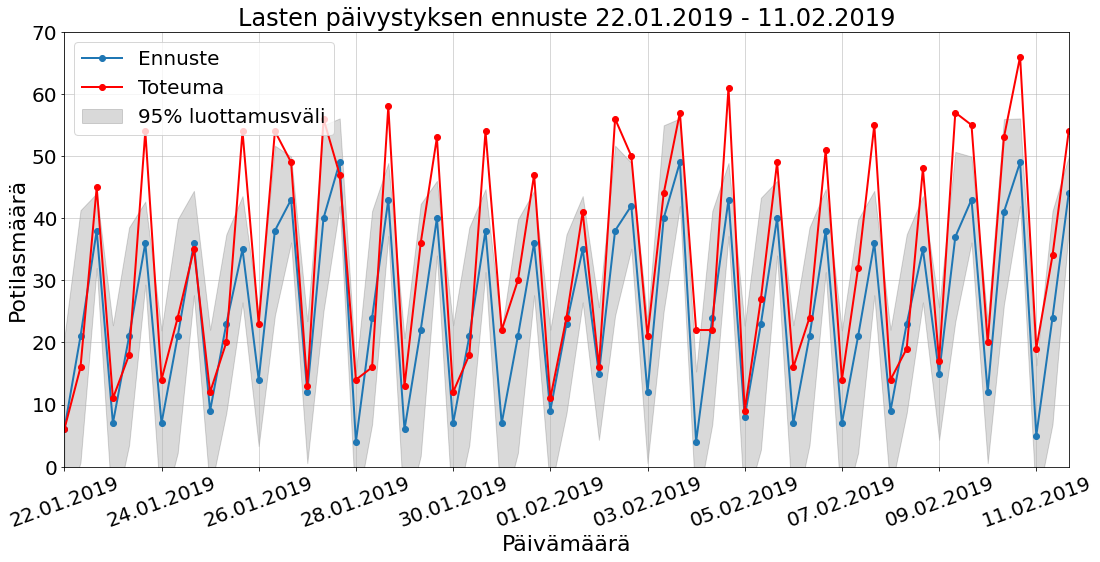

In [35]:
mean_series = final_results['0'][21*3:42*3]
start_weekday = start_day.weekday()
week = np.array(train_ninety_five).reshape((21, 1))
week = pd.DataFrame(week)
ninety_five = pd.concat([week.loc[start_weekday:], week, week, week, week, week, week]).reset_index(drop=True)[21*3:42*3].squeeze()
lower_series = final_results['0'][21*3:42*3] - ninety_five
upper_series = final_results['0'][21*3:42*3] + ninety_five
ER_true = df_test_day.patient_count.reset_index(drop=True)[21*3:42*3]
time_range = df_test_day.index[21*3:42*3]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(18, 8))
plt.plot(mean_series, marker='o', linewidth=2)
plt.plot(ER_true, color='red', marker='o', linewidth=2)
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)
plt.ylim([0, 70])
plt.xticks(ticks=ER_true.index, labels=pd.date_range(start=time_range[0], end=time_range[-1], freq='8H').strftime('%d.%m.%Y'), rotation=20)
plt.locator_params(axis='x', nbins=11)
plt.title("Lasten päivystyksen ennuste 22.01.2019 - 11.02.2019", fontsize=24)
plt.legend(["Ennuste", "Toteuma", "95% luottamusväli"], loc="upper left")
plt.xlabel('Päivämäärä', fontsize=22)
plt.ylabel('Potilasmäärä', fontsize=22)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

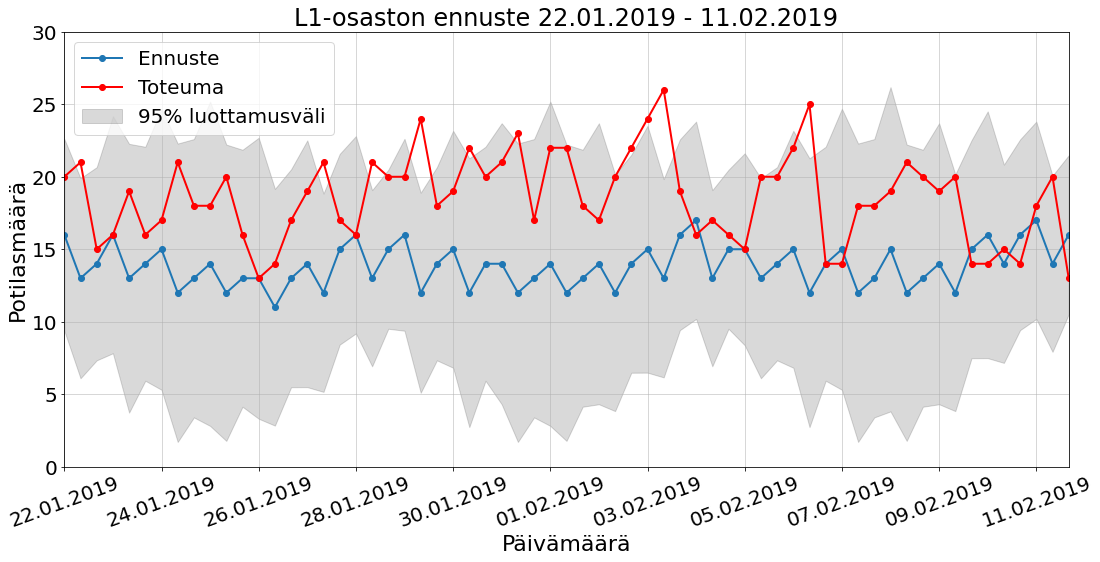

In [34]:
mean_series = final_results['1'][21*3:42*3]
start_weekday = start_day.weekday()
week = np.array(ward_ninety_five).reshape((21, 1))
week = pd.DataFrame(week)
ninety_five = pd.concat([week.loc[start_weekday:], week, week, week, week, week, week]).reset_index(drop=True)[21*3:42*3].squeeze()
lower_series = final_results['1'][21*3:42*3] - ninety_five
upper_series = final_results['1'][21*3:42*3] + ninety_five
new_index = np.arange(21*3, 42*3)
L1_true = ward_test_day.patient_count.reset_index(drop=True)[21*3:42*3]
time_range = df_test_day.index[21*3:42*3]

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(18, 8))
plt.plot(mean_series, marker='o', linewidth=2)
plt.plot(L1_true, color='red', marker='o', linewidth=2)
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)
plt.ylim([0, 30])
plt.xticks(ticks=L1_true.index, labels=pd.date_range(start=time_range[0], end=time_range[-1], freq='8H').strftime('%d.%m.%Y'), rotation=20)
plt.locator_params(axis='x', nbins=11)
plt.title("L1-osaston ennuste 22.01.2019 - 11.02.2019", fontsize=24)
plt.legend(["Ennuste", "Toteuma", "95% luottamusväli"], loc="upper left")
plt.xlabel('Päivämäärä', fontsize=22)
plt.ylabel('Potilasmäärä', fontsize=22)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()